In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
for row in session.query(Measurement, Station.name).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x00000206A51F3E08>, 'WAIKIKI 717.2, HI US')
(<sqlalchemy.ext.automap.measurement object at 0x00000206A51F3E08>, 'KANEOHE 838.1, HI US')
(<sqlalchemy.ext.automap.measurement object at 0x00000206A51F3E08>, 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
(<sqlalchemy.ext.automap.measurement object at 0x00000206A51F3E08>, 'PEARL CITY, HI US')
(<sqlalchemy.ext.automap.measurement object at 0x00000206A51F3E08>, 'UPPER WAHIAWA 874.3, HI US')


# Exploratory Climate Analysis

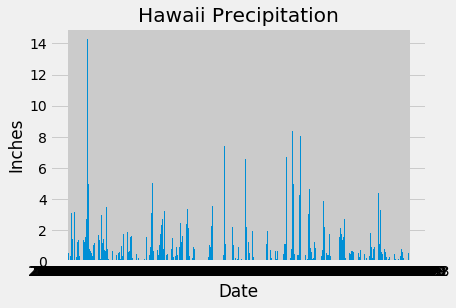

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date_ravel, = list(np.ravel(max_date))

prior_date = dt.date(2016, 8, 23)
 
# Perform a query to retrieve the data and precipitation scores
measurement_sel = [Measurement.date, Measurement.prcp]
last_year = session.query(*measurement_sel).filter(Measurement.date > prior_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_pd = pd.DataFrame(last_year)
last_year_pd.reset_index(inplace=True)
del last_year_pd["index"]

# Sort the dataframe by date
last_year_pd = last_year_pd.sort_values(by = "date")
last_year_pd = last_year_pd.dropna()

last_year_bydate_pd = last_year_pd.groupby(["date"])

last_year_bydate_pd = last_year_bydate_pd.sum()

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = last_year_bydate_pd.index
y_axis = last_year_bydate_pd.prcp

plt.title("Hawaii Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")

plt.bar(x_axis, y_axis)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_bydate_pd.describe()

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [13]:
# Design a query to show how many stations are available in this dataset?
names = session.query(Station).group_by(Station.name).count()
print(names)

9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_sel = session.query(*station_sel).all()
station_pd = pd.DataFrame(station_sel)

measurement_select = [Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
measurement_last_year = session.query(*measurement_select).filter(Measurement.date > prior_date).all()
measurement_last_year_pd = pd.DataFrame(measurement_last_year)

merge_pd = pd.merge(station_pd, measurement_last_year_pd, on="station")

stations_pd = merge_pd.groupby("station").count()
stations_pd.sort_values("name", inplace=True, ascending=False)
stations_pd.head(20)

,name,latitude,longitude,elevation,date,prcp,tobs
station,,,,,,,
USC00519397,360,360,360,360,360,358,360
USC00519281,351,351,351,351,351,351,351
USC00516128,348,348,348,348,348,327,348
USC00513117,342,342,342,342,342,342,342
USC00519523,336,336,336,336,336,313,336
USC00514830,304,304,304,304,304,264,304
USC00517948,182,182,182,182,182,60,182


In [15]:
stations_pd_max = stations_pd.head(1)
stations_pd_max.head()

,name,latitude,longitude,elevation,date,prcp,tobs
station,,,,,,,
USC00519397,360,360,360,360,360,358,360


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#station_max_active = merge_pd[(merge_pd.index == stations_pd_max_pd.index)]
station_max_active = merge_pd[(merge_pd["station"] == "USC00519397")]
print(station_max_active)

         station                  name  latitude  longitude  elevation  \
0    USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
1    USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
2    USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
3    USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
4    USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
..           ...                   ...       ...        ...        ...   
355  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
356  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
357  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
358  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
359  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   

           date  prcp  tobs  
0    2016-08-24  0.08  79.0  
1    2016-08-25  0.08  80.0  
2    2016-08-26  0.00

In [17]:
station_max_active.agg([pd.np.min, pd.np.max, pd.np.mean])

C:\Users\aclif\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


,station,name,latitude,longitude,elevation,date,prcp,tobs
amin,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2016-08-24,0.000000,60.000000
amax,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2017-08-23,2.620000,87.000000
mean,NaN,NaN,21.2716,-157.8168,3.0,NaN,0.044944,75.194444


In [18]:
station_max_active.min(axis = 0)

station               USC00519397
name         WAIKIKI 717.2, HI US
latitude                  21.2716
longitude                -157.817
elevation                       3
date                   2016-08-24
prcp                            0
tobs                           60
dtype: object

In [19]:
station_max_active.max(axis = 0)

station               USC00519397
name         WAIKIKI 717.2, HI US
latitude                  21.2716
longitude                -157.817
elevation                       3
date                   2017-08-23
prcp                         2.62
tobs                           87
dtype: object

In [20]:
station_max_active.mean(axis = 0)

latitude      21.271600
longitude   -157.816800
elevation      3.000000
prcp           0.044944
tobs          75.194444
dtype: float64

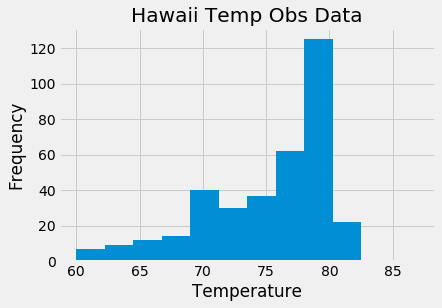

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

x_axis = station_max_active["tobs"]
plt.hist(x_axis, bins=12)

plt.title("Hawaii Temp Obs Data")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
